Step 1: Loading the dataset

In [7]:
import pandas as pd

df = pd.read_csv('online_retail.csv')
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.sample(8)


Shape: (541909, 8)
Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
60135,541421,22249,DECORATION WHITE CHICK MAGIC GARDEN,29,1/17/2011 17:44,0.79,NaN,United Kingdom
467651,576364,22557,PLASTERS IN TIN VINTAGE PAISLEY,4,11/14/2011 17:40,1.65,15009.0,United Kingdom
117376,546384,22262,FELT EGG COSY CHICKEN,19,3/11/2011 13:03,0.85,15311.0,United Kingdom
225698,556728,21876,POTTERING MUG,3,6/14/2011 11:36,1.25,15719.0,United Kingdom
456339,575687,20971,PINK BLUE FELT CRAFT TRINKET BOX,72,11/10/2011 16:03,1.25,16126.0,United Kingdom
213804,555558,22383,LUNCH BAG SUKI DESIGN,2,6/5/2011 14:06,1.65,14159.0,United Kingdom
275084,560934,23208,LUNCH BAG VINTAGE LEAF DESIGN,20,7/22/2011 10:48,1.65,16722.0,United Kingdom
126926,547106,22692,DOORMAT WELCOME TO OUR HOME,1,3/21/2011 11:24,7.95,15039.0,United Kingdom


Step 2: Checking for null values

In [9]:
print(df.isnull().sum())
df.info()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Step 3: Dropping rows that don't include CustomerID

In [ ]:
df_all = df.copy()  # full dataset
df = df[df['CustomerID'].notna()]  # filtered for feature engineering

In [14]:
# Reset index after drop
df_clean = df.reset_index(drop=True)

In [43]:
df_clean = df_clean[df_clean['Quantity'] > 0]
df_clean.shape

(397924, 8)

After dropping, the dataset shape is: (397924, 8)

Create Revenue = Quantity * UnitPrice

Step 4: Creating new features

In [45]:
# Convert Quantity and UnitPrice to numeric (if not already)
df_clean['Quantity'] = pd.to_numeric(df_clean['Quantity'], errors='coerce')
df_clean['UnitPrice'] = pd.to_numeric(df_clean['UnitPrice'], errors='coerce')

# Revenue column
df_clean['Revenue'] = df_clean['Quantity'] * df_clean['UnitPrice']


Parse InvoiceDate to date time

In [46]:
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], format='%m/%d/%Y %H:%M')


In [47]:
df_clean['InvoiceDate'].head()

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]

Extract Date & Time Features

From InvoiceDate, create these features:

    Year

    Month

    Day

    Weekday (0 = Monday, 6 = Sunday)

    Hour

In [48]:
df_clean['Year'] = df_clean['InvoiceDate'].dt.year
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean['Day'] = df_clean['InvoiceDate'].dt.day
df_clean['Weekday'] = df_clean['InvoiceDate'].dt.weekday
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour


In [49]:
df_clean.sample(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Year,Month,Day,Weekday,Hour
339071,575148,23133,LARGE IVORY HEART WALL ORGANISER,2,2011-11-08 15:48:00,8.25,13867.0,United Kingdom,16.5,2011,11,8,1,15
16133,538354,21035,SET/2 RED RETROSPOT TEA TOWELS,6,2010-12-10 15:45:00,2.95,16873.0,United Kingdom,17.7,2010,12,10,4,15
271921,569046,23329,DECORATIVE WICKER HEART LARGE,12,2011-09-30 10:48:00,1.65,14422.0,United Kingdom,19.8,2011,9,30,4,10


Step 5:  Cyclical Encoding of Month & Weekday

In [50]:
import numpy as np

# Month cyclical encoding
df_clean['Month_sin'] = np.sin(2 * np.pi * df_clean['Month'] / 12)
df_clean['Month_cos'] = np.cos(2 * np.pi * df_clean['Month'] / 12)

# Weekday cyclical encoding
df_clean['Weekday_sin'] = np.sin(2 * np.pi * df_clean['Weekday'] / 7)
df_clean['Weekday_cos'] = np.cos(2 * np.pi * df_clean['Weekday'] / 7)


Step 6:  Create Interaction Features
    Bin Revenue into Ranges (High/Medium/Low)
    Create a Feature: Is Weekday/Weekend?

In [51]:
df_clean['Revenue_bin'] = pd.qcut(df_clean['Revenue'], q=3, labels=['Low', 'Medium', 'High'])
df_clean['Is_Weekend'] = df_clean['Weekday'].apply(lambda x: 1 if x >= 5 else 0)


Step 7: Visualize Impact of New Features on Spending
     1. Month-wise Revenue by Year (Line Plot)
     2. Average Revenue by Weekday

We’ll use Seaborn and Matplotlib to explore how features like Month, Weekday, Revenue_bin, and Is_Weekend affect revenue.

In [57]:
df_clean['InvoiceDate'].describe()

count                           397924
mean     2011-07-10 23:43:36.912475648
min                2010-12-01 08:26:00
25%                2011-04-07 11:12:00
50%                2011-07-31 14:39:00
75%                2011-10-20 14:33:00
max                2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

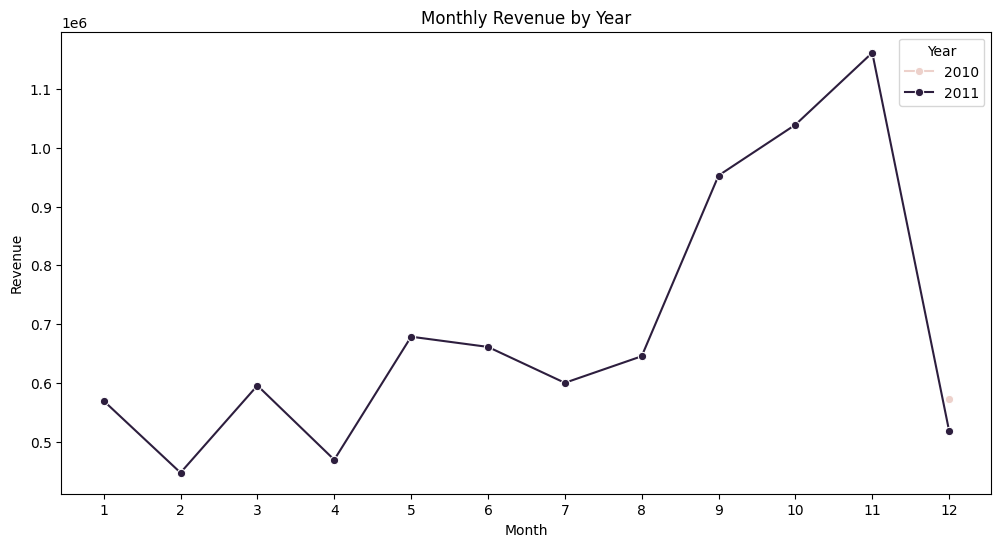

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
monthly_revenue = df_clean.groupby(['Year', 'Month'])['Revenue'].sum().reset_index()

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(x='Month', y='Revenue', hue='Year', data=monthly_revenue, marker='o')
plt.title('Monthly Revenue by Year')
plt.xticks(ticks=range(1,13))  # To show 1 to 12
plt.show()

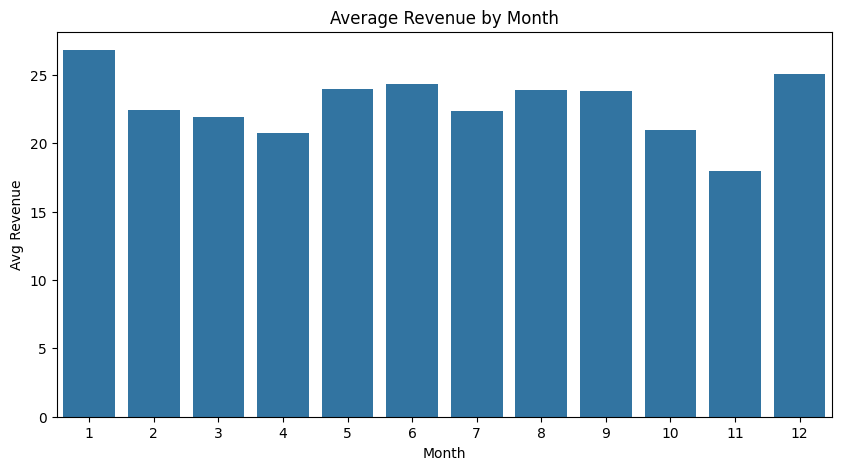

In [ ]:


monthly_avg = df_clean.groupby('Month')['Revenue'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(x='Month', y='Revenue', data=monthly_avg)
plt.title('Average Revenue by Month')
plt.ylabel('Avg Revenue')
plt.show()


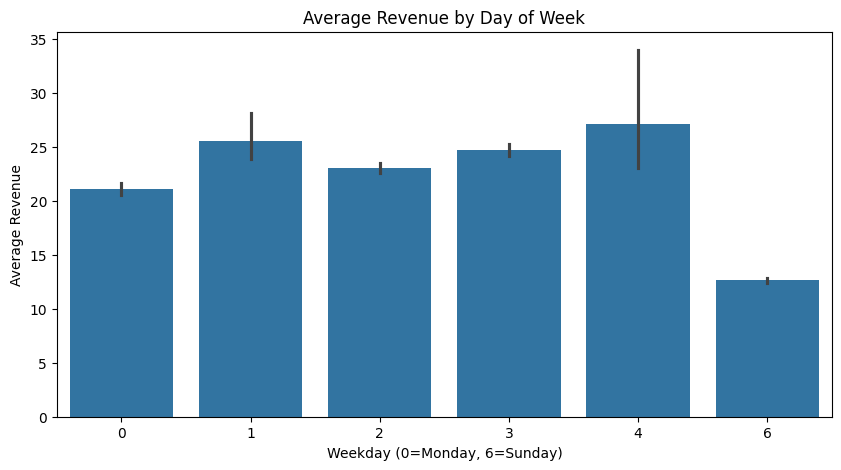

In [59]:
plt.figure(figsize=(10,5))
sns.barplot(x='Weekday', y='Revenue', data=df_clean, estimator=np.mean)
plt.title('Average Revenue by Day of Week')
plt.xlabel('Weekday (0=Monday, 6=Sunday)')
plt.ylabel('Average Revenue')
plt.show()



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1108\1015130749.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Revenue_bin', data=df_clean, palette='Set2')


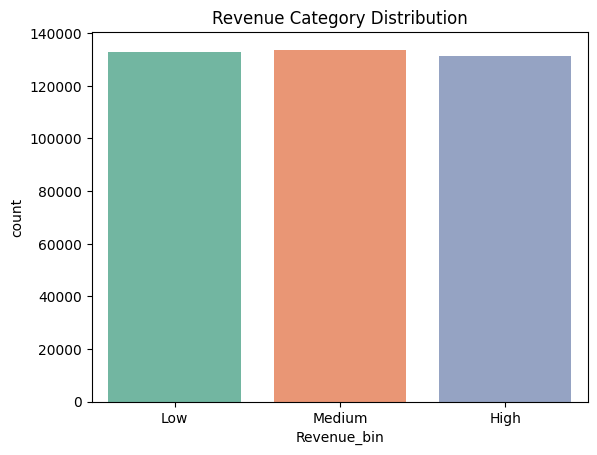

In [61]:
sns.countplot(x='Revenue_bin', data=df_clean, palette='Set2')
plt.title('Revenue Category Distribution')
plt.show()

